### Basic `MuJoCo` usage

In [1]:
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt
import mujoco
np.set_printoptions(precision=2,suppress=True,linewidth=100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.2]


### Very simple model

""

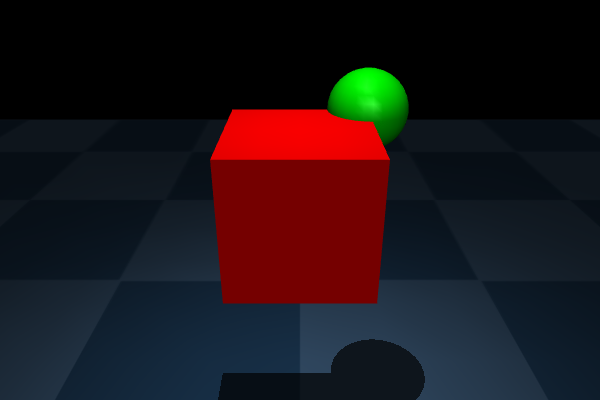

In [2]:
free_body_MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" 
    rgb2=".2 .3 .4" width="300" height="300" mark="edge" markrgb=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="2 2" texuniform="true"
    reflectance=".2"/>
  </asset>

  <worldbody>
    <light pos="0 0 1" mode="trackcom"/>
    <geom name="ground" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid" solimp=".99 .99 .01" solref=".001 1"/>
    <body name="box_and_sphere" pos="0 0 0">
      <freejoint/>
      <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1" solimp=".99 .99 .01"  solref=".001 1"/>
      <geom name="green_sphere" size=".06" pos=".1 .1 .1" rgba="0 1 0 1"/>
      <camera name="fixed" pos="0 -.6 .3" xyaxes="1 0 0 0 1 2"/>
      <camera name="track" pos="0 -.6 .3" xyaxes="1 0 0 0 1 2" mode="track"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(free_body_MJCF)
renderer = mujoco.Renderer(model, 400, 600)
data = mujoco.MjData(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data, "fixed")
media.show_image(renderer.render())

In [3]:
n_frames = 200

# visualize contact frames and forces, make body transparent
options = mujoco.MjvOption()
mujoco.mjv_defaultOption(options)
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
options.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True

# tweak scales of contact visualization elements
model.vis.scale.contactwidth = 0.1
model.vis.scale.contactheight = 0.03
model.vis.scale.forcewidth = 0.05
model.vis.map.force = 0.3

# random initial rotational velocity:
mujoco.mj_resetData(model, data)
data.qvel[3:6] = 5*np.random.randn(3)

# simulate and render
for i in range(n_frames):
    while data.time < i/120.0: #1/4x real time
        mujoco.mj_step(model, data)
    renderer.update_scene(data, "track", options)
    frame = renderer.render()
    frames.append(frame.copy())

# show video
media.show_video(frames, fps=30)

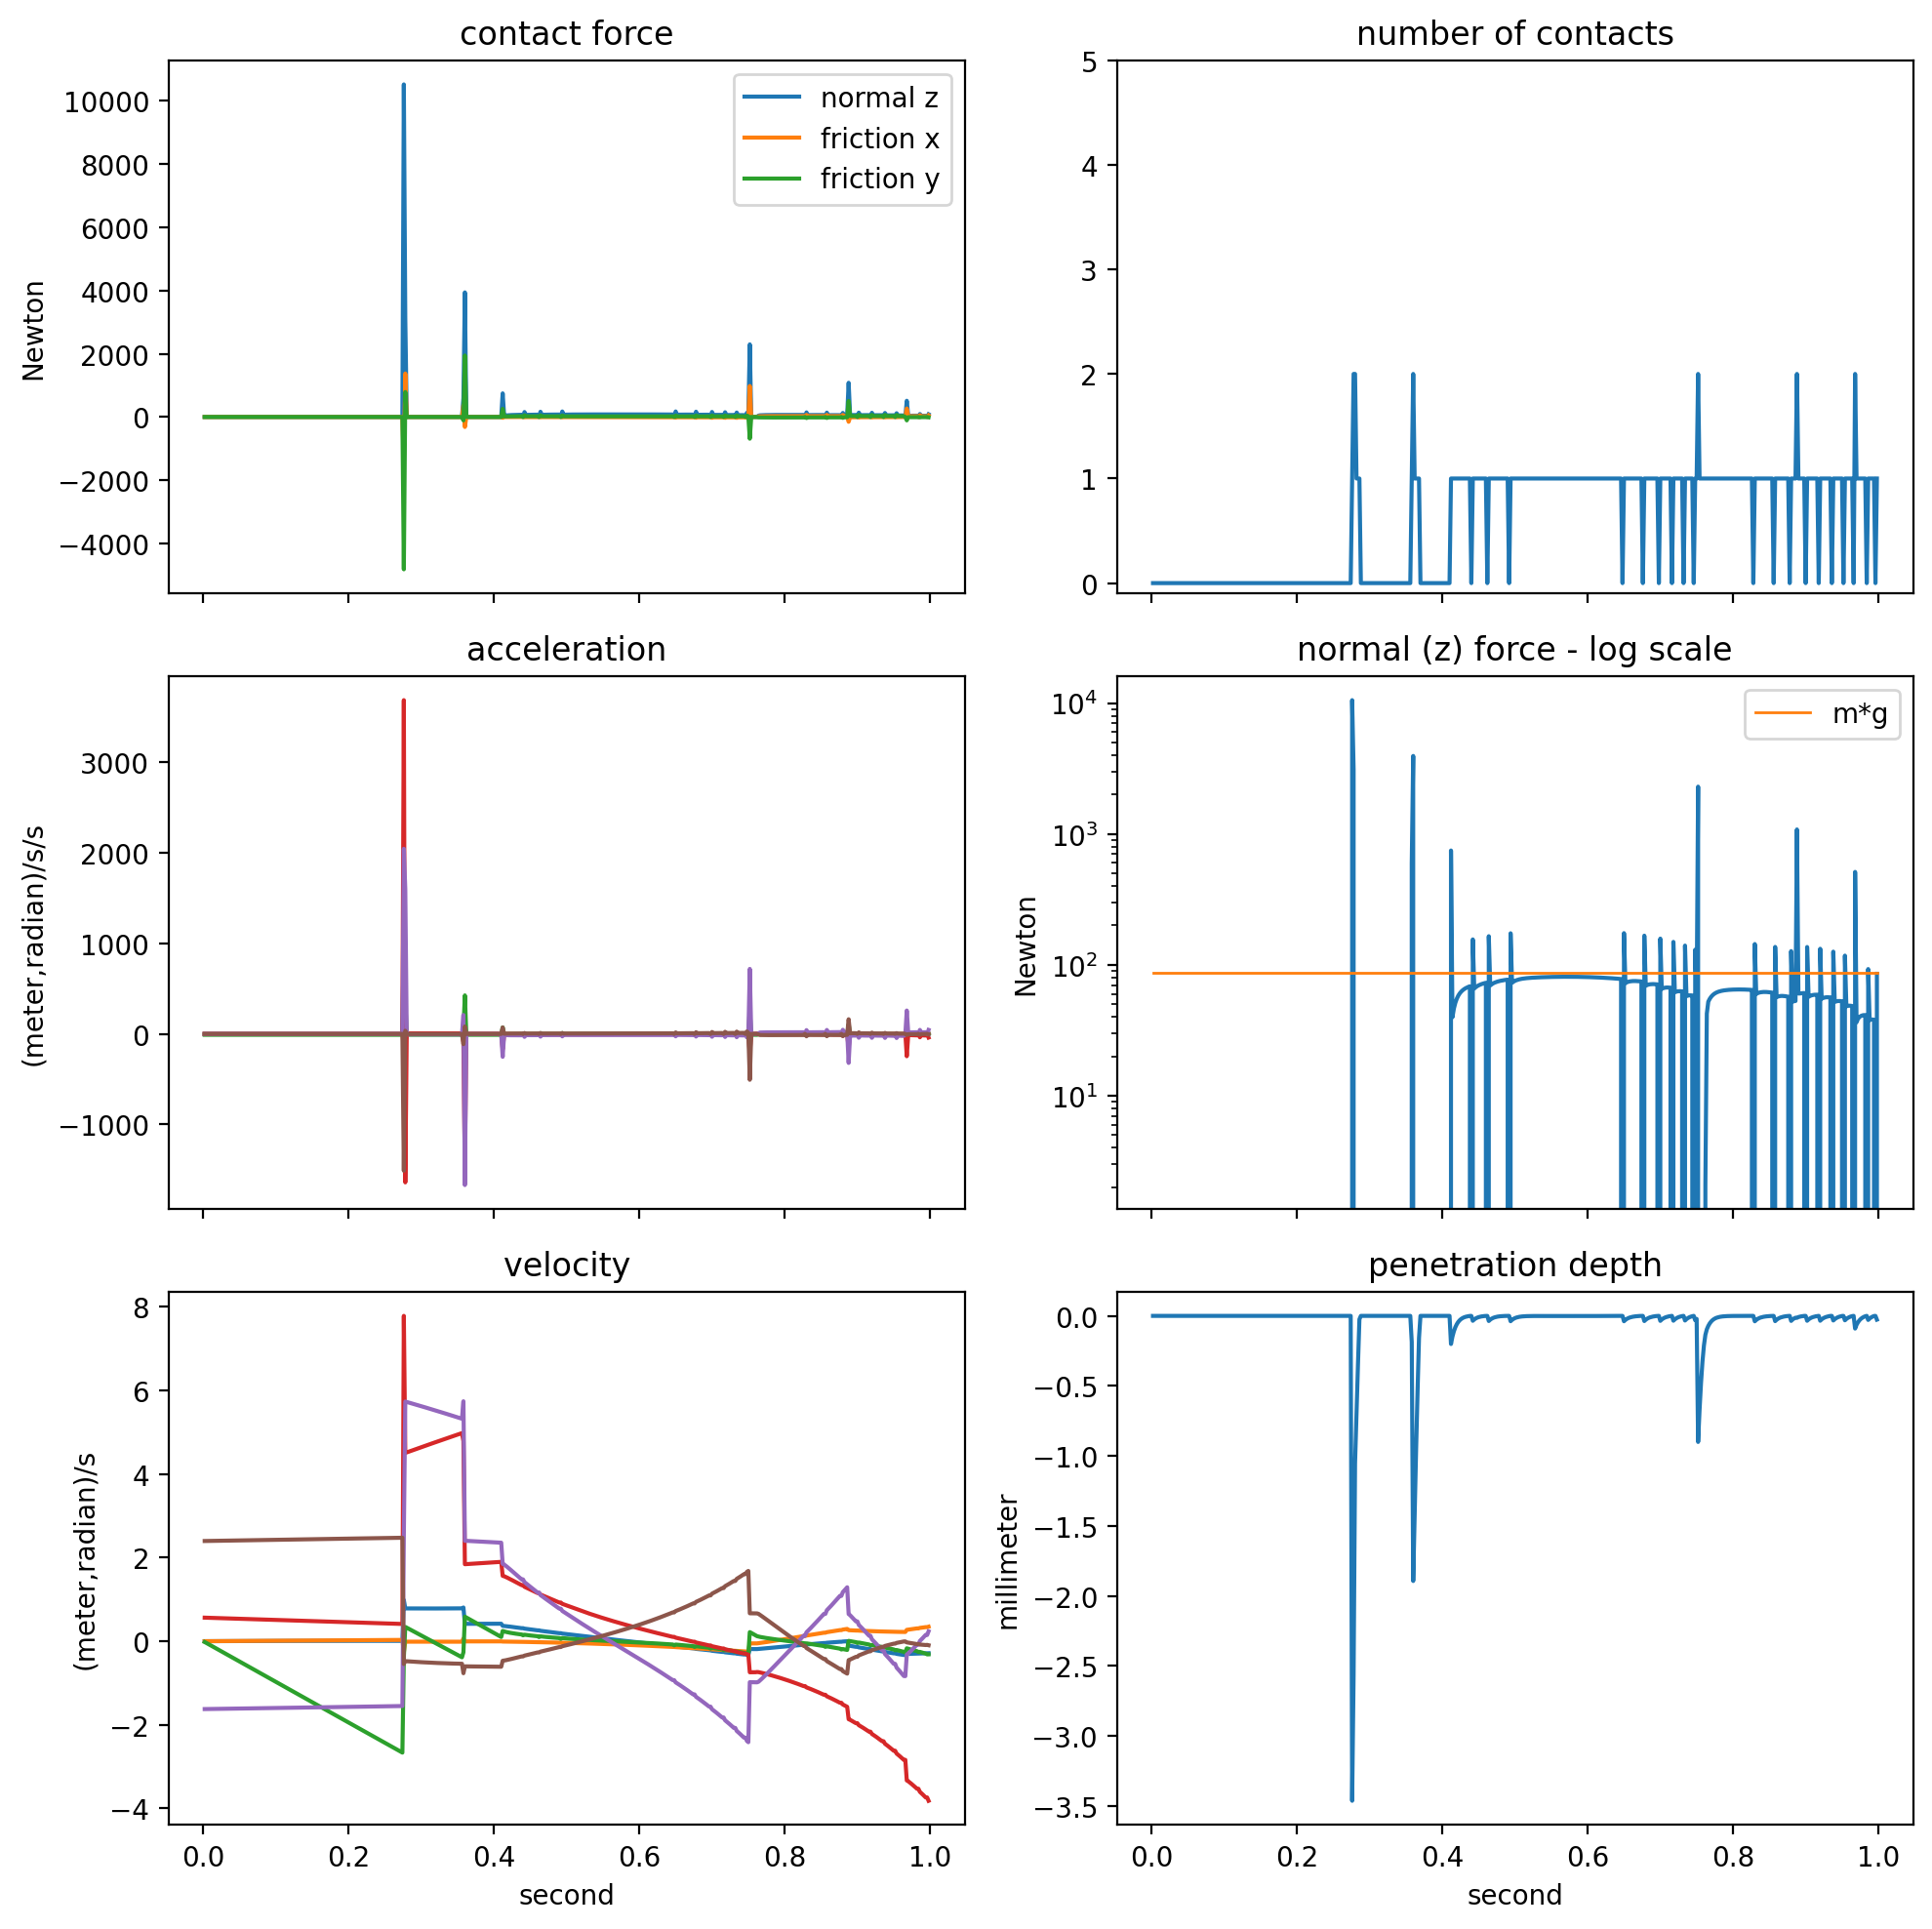

In [4]:
n_steps = 499

# allocate
sim_time = np.zeros(n_steps)
ncon = np.zeros(n_steps)
force = np.zeros((n_steps,3))
velocity = np.zeros((n_steps, model.nv))
penetration = np.zeros(n_steps)
acceleration = np.zeros((n_steps, model.nv))
forcetorque = np.zeros(6)

# random initial rotational velocity:
mujoco.mj_resetData(model, data)
data.qvel[3:6] = 2*np.random.randn(3)

# simulate and save data
for i in range(n_steps):
    mujoco.mj_step(model, data)
    sim_time[i] = data.time
    ncon[i] = data.ncon
    velocity[i] = data.qvel[:]
    acceleration[i] = data.qacc[:]
    # iterate over active contacts, save force and distance
    for j,c in enumerate(data.contact):
        mujoco.mj_contactForce(model, data, j, forcetorque)
        force[i] += forcetorque[0:3]
        penetration[i] = min(penetration[i], c.dist)
# plot
_, ax = plt.subplots(3, 2, sharex=True, figsize=(10, 10))

lines = ax[0,0].plot(sim_time, force)
ax[0,0].set_title('contact force')
ax[0,0].set_ylabel('Newton')
ax[0,0].legend(iter(lines), ('normal z', 'friction x', 'friction y'));

ax[1,0].plot(sim_time, acceleration)
ax[1,0].set_title('acceleration')
ax[1,0].set_ylabel('(meter,radian)/s/s')

ax[2,0].plot(sim_time, velocity)
ax[2,0].set_title('velocity')
ax[2,0].set_ylabel('(meter,radian)/s')
ax[2,0].set_xlabel('second')

ax[0,1].plot(sim_time, ncon)
ax[0,1].set_title('number of contacts')
ax[0,1].set_yticks(range(6))

ax[1,1].plot(sim_time, force[:,0])
ax[1,1].set_yscale('log')
ax[1,1].set_title('normal (z) force - log scale')
ax[1,1].set_ylabel('Newton')
z_gravity = -model.opt.gravity[2]
mg = model.body("box_and_sphere").mass[0] * z_gravity
mg_line = ax[1,1].plot(sim_time, np.ones(n_steps)*mg, label='m*g', linewidth=1)
ax[1,1].legend()

ax[2,1].plot(sim_time, 1000*penetration)
ax[2,1].set_title('penetration depth')
ax[2,1].set_ylabel('millimeter')
ax[2,1].set_xlabel('second')

plt.tight_layout()